# Pairwise Conditional Gradient

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
class PARAM:
     def __init__(self):
        self._Tmax = 0
        self._TOL = 0
        self._verbose = True
        self._pureFW = 1 # to not use away steps...
       
     # function to get value of _age
     def get_Tmax(self):
         return self._Tmax
       
     # function to set value of _age
     def set_Tmax(self, a):
         self._Tmax = a
  
     # function to delete _age attribute
     def del_Tmax(self):
         del self._Tmax

     def get_TOL(self):
         return self._TOL
       
     # function to set value of _age
     def set_TOL(self, a):
         self._TOL = a
  
     # function to delete _age attribute
     def del_TOL(self):
         del self._TOL

     def get_verbose(self):
         return self._verbose
       
     # function to set value of _age
     def set_verbose(self, a):
         self._verbose = a
  
     # function to delete _age attribute
     def del_verbose(self):
         del self._verbose

     def get_pureFW(self):
         return self._pureFW
       
     # function to set value of _age
     def set_pureFW(self, a):
         self._pureFW = a
  
     # function to delete _age attribute
     def del_pureFW(self):
         del self._pureFW
     
     Tmax = property(get_Tmax, set_Tmax, del_Tmax) 
     TOL = property(get_TOL, set_TOL, del_TOL) 
     verbose = property(get_verbose, set_verbose, del_verbose) 
     pureFW = property(get_verbose, set_pureFW, del_pureFW) 
       
  
opts = PARAM()
  


In [ ]:
def find(s):
    # print(s)
    index = []
    ls = s.tolist()
    for l in ls:
        index.append(l[0])
    return index 

In [ ]:
def away_step(grad, S, I_active):
    s = np.dot(grad.T, S[:,I_active])
    idx = np.argmax(s)
    id = I_active[idx]
    return id

In [ ]:
def cost_fun(y, A, b):
    by = np.dot(b.T, y)
    ay = np.dot(A, y)
    cost =.5 * np.dot(y.T, ay) + by
    return cost


In [ ]:
class KeyStore:

    def __init__(self):
        self.store = []

    def isKey(self, key):
        for item in self.store:
            k, value = item
            if np.array_equal(k, key):
                return True
        return False

    def set_key(self, key, value):
        self.store.append((key, value))

    def get_value(self, key):
        for item in self.store:
            k, value = item
            if np.array_equal(k, key):
                return value
        assert("not found key!")

    def delete(self, key):
        idx = -1
        for i in range(len(self.store)):
            k, value = self.store[i]
            if np.array_equal(k, key):
                idx = i
        if idx != -1:
            self.store.pop(idx)

In [ ]:
def PFW(x_0, S_0, alpha_0, A, b, fun_optim, cost_fun, ids, opts):
    it   = 0
    minf = 0
    minx = []

    res = {}

    x_t         = x_0
    S_t         = S_0
    alpha_t     = alpha_0

    eps = 1e-16

    mapping = KeyStore()

    max_index = S_t.shape[1] - 1 # keep track of size of S_t
    for index in range(0, max_index):
        mapping.set_key(np.expand_dims(S_t[:,index], 1), index)
    I_active = find(np.argwhere(alpha_t > 0))

    fvalues = {}
    gap_values = {}
    number_drop = 0 # counting drop steps (max stepsize for away step)

    print('running pairwise FW, for at most {} iterations\n'.format(opts.Tmax))

    # optimization: 

    while it <= opts.Tmax:
        it = it + 1

        # gradient:
        grad        = np.dot(A, x_t) + b

        # cost function:
        f_t = cost_fun(x_t, A, b)

        # towards direction search:
        s_FW     = fun_optim( grad, ids ) # the linear minimization oracle
        d_FW     = s_FW - x_t

        # duality gap:
        gap = np.dot(- d_FW.T, grad)

        fvalues[it-1] = f_t
        gap_values[it-1] = gap
        
        if opts.verbose:
            print('it = {} -  f = {} - gap={}\n'.format(it, f_t, gap))

        if gap < opts.TOL:
            print('end of PFW: reach small duality gap (gap={})\n'.format(gap))
            break
        
        # away direction search:
        if S_t.shape[1] > 0:
            id_A   = away_step(grad, S_t, I_active)
            v_A    = np.expand_dims(S_t[:, id_A], 1)
            #d_A    = x_t - v_A
            alpha_max = alpha_t[0, id_A]
        else:
            print('error: empty support set at step (it={})\n'.format(it))

            # construct pair direction (between towards and away):

        d = s_FW - v_A #was for away: d_A
        max_step = alpha_max # was for away: alpha_max / (1 - alpha_max)
        
        # line search: (same as away, but different d)

        step = (-  np.dot(grad.T , d) / np.dot(np.dot( d.T, A), d))[0, 0]

        step = max(0, min(step, max_step ))

        if step < -eps:
            # not a descent direction???
            print('ERROR -- not descent direction???')
            keyboard

        # doing steps and updating active set:
        
        # away part of the step step:
        # alpha_t = (1+step)*alpha_t % note that inactive should stay at 0;
        if abs(step - max_step) < 10*eps:
            # drop step:
            number_drop = number_drop+1
            alpha_t[0, id_A] = 0
            I_active.remove(id_A)# remove from active set
            #TODO: could possibly also remove it from S_t
        else:
            alpha_t[0,id_A] = alpha_t[0, id_A] - step
            
        # towards part of the step:
        # alpha_t = (1-step)*alpha_t
            
        # is this s_FW a new vertex?
        h = s_FW
        if not mapping.isKey(h):
            # we need to add vertex in S_t:
            max_index = max_index + 1
            mapping.set_key(h, max_index)
            S_t = np.hstack((S_t, s_FW))
            id_FW = max_index
            alpha_t = np.append(alpha_t, np.ones(shape=(1,1)) * step, axis=1) # this increase size of alpha_t btw
            I_active.append(id_FW)
        else:
            id_FW = mapping.get_value(h)
            if alpha_t[0, id_FW] < eps:
                # we already had atom in 'correction poytope', but it was not
                # active, so now track it as active:
                I_active.append(id_FW)
            alpha_t[0, id_FW] = alpha_t[0, id_FW] + step
            
        # exceptional case: stepsize of 1, this collapses the active set!
        if step > 1-eps:
            I_active = [id_FW]
        
        x_t = x_t + step * d
    
    res["primal"] = fvalues
    res["gap"] = gap_values
    res["number_drop"] = number_drop
    res["S_t"] = S_t
    res["alpha_t"] = alpha_t
    res["x_t"] = x_t

    return x_t,f_t,res


In [ ]:
import scipy.io

Image Colocation

In [ ]:
def solver_image(x):
    idx  = np.argmin(x)
    y    = np.zeros(shape=x.shape)
    y[idx] = 1
    return y

In [ ]:
def solver_images(x, ids):
    y   = np.zeros(shape=x.shape)
    for i in range(0 , ids.shape[0]):
        y[ids[i,0] : ids[i, 1] + 1] = solver_image(x[ids[i,0] : ids[i, 1] + 1])
    return y

In [ ]:
def get_first_indice(arr):
    ind = []
    unique_set = set(arr.tolist())
    for i in unique_set:
        idx = np.argwhere(arr == i)
        ind.append(min(idx)[0])
    return ind

In [ ]:
def get_last_indice(arr):
    ind = []
    unique_set = set(arr.tolist())
    for i in unique_set:
        idx = np.argwhere(arr == i)
        ind.append(max(idx)[0])
    return ind


In [ ]:
def init_images(var_index):
    
    N = var_index.shape[0]
    a, b, c = np.unique(var_index[:, 0:2], return_index=True, return_inverse=True, axis=0)
    ib = np.expand_dims(np.array(get_first_indice(c)), 1)
    ie = np.expand_dims(np.array(get_last_indice(c)), 1)
    ids = np.hstack((ib, ie))

    fun_optim = solver_images

    n_imgs = ids.shape[0]
    boxes_per_img = int(N / n_imgs)
    x_0     = np.ones((N,1)) / boxes_per_img
    S_0     = np.zeros((N, boxes_per_img))
    alpha_0 = np.ones((1, boxes_per_img)) / boxes_per_img
    for i in  range(1, boxes_per_img):
        index = ids[:,0] + (i-1) * (N + 1)
        for j in index.tolist():
            row = int(j / N)
            col = j - N * row 
            S_0[col, row] = 1
        # print(S_0)
    return x_0, S_0, alpha_0, ids

In [ ]:
from scipy.io import loadmat
annots = loadmat('/work/aeroplane_data_small.mat')
print(annots.keys())

dict_keys(['__header__', '__version__', '__globals__', 'b', 'A', 'var_index', 'edge_index'])


In [ ]:
A = annots['A']
b = annots['b']
var_index = annots['var_index']
edge_index = annots['edge_index']


In [ ]:
 # 5 group images, number of images in group is differ
 # 20 boxes per 1 images
 # 33 images
print(A.shape)

(660, 660)


In [ ]:
print(b.shape)

(660, 1)


In [ ]:
print(var_index[var_index[:, 0] == 4])
print(set(var_index[:,0]))

[[ 4  1  1]
 [ 4  1  2]
 [ 4  1  3]
 [ 4  1  4]
 [ 4  1  5]
 [ 4  1  6]
 [ 4  1  7]
 [ 4  1  8]
 [ 4  1  9]
 [ 4  1 10]
 [ 4  1 11]
 [ 4  1 12]
 [ 4  1 13]
 [ 4  1 14]
 [ 4  1 15]
 [ 4  1 16]
 [ 4  1 17]
 [ 4  1 18]
 [ 4  1 19]
 [ 4  1 20]
 [ 4  2  1]
 [ 4  2  2]
 [ 4  2  3]
 [ 4  2  4]
 [ 4  2  5]
 [ 4  2  6]
 [ 4  2  7]
 [ 4  2  8]
 [ 4  2  9]
 [ 4  2 10]
 [ 4  2 11]
 [ 4  2 12]
 [ 4  2 13]
 [ 4  2 14]
 [ 4  2 15]
 [ 4  2 16]
 [ 4  2 17]
 [ 4  2 18]
 [ 4  2 19]
 [ 4  2 20]
 [ 4  3  1]
 [ 4  3  2]
 [ 4  3  3]
 [ 4  3  4]
 [ 4  3  5]
 [ 4  3  6]
 [ 4  3  7]
 [ 4  3  8]
 [ 4  3  9]
 [ 4  3 10]
 [ 4  3 11]
 [ 4  3 12]
 [ 4  3 13]
 [ 4  3 14]
 [ 4  3 15]
 [ 4  3 16]
 [ 4  3 17]
 [ 4  3 18]
 [ 4  3 19]
 [ 4  3 20]
 [ 4  4  1]
 [ 4  4  2]
 [ 4  4  3]
 [ 4  4  4]
 [ 4  4  5]
 [ 4  4  6]
 [ 4  4  7]
 [ 4  4  8]
 [ 4  4  9]
 [ 4  4 10]
 [ 4  4 11]
 [ 4  4 12]
 [ 4  4 13]
 [ 4  4 14]
 [ 4  4 15]
 [ 4  4 16]
 [ 4  4 17]
 [ 4  4 18]
 [ 4  4 19]
 [ 4  4 20]]
{1, 2, 3, 4, 5}


In [ ]:
# a, b, c = np.unique(var_index[:, 0:2], return_index=True, return_inverse=True, axis=0)
# print(get_first_indice(c))
# print(get_last_indice(c))

            
# is_imgs = True # true : images / false : videos
# is_test = True

x_0, S_0, alpha_0, ids = init_images(var_index)

opts.Tmax  = 100 # max number of iteration
opts.TOL   = 1e-8 # tolerance for convergence
opts.verbose = True

opts.pureFW = 0
x_t,f_t, resPairFW = PFW(x_0, S_0, alpha_0, A, b, solver_images, cost_fun, ids, opts)


running pairwise FW, for at most 100 iterations

it = 1 -  f = [[0.15013038]] - gap=[[0.07284428]]

it = 2 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 3 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 4 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 5 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 6 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 7 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 8 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 9 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 10 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 11 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 12 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 13 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 14 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 15 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 16 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 17 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 18 -  f = [[0.14753692]] - gap=[[0.06983381]]

it = 19 -  f = [[0.14753

In [ ]:
# import matplotlib.pyplot as plt
# gaps = [v[0] for k,v in resPairFW["gap"].items()]
# plt.plot([i for i in range(len(gaps))], gaps)

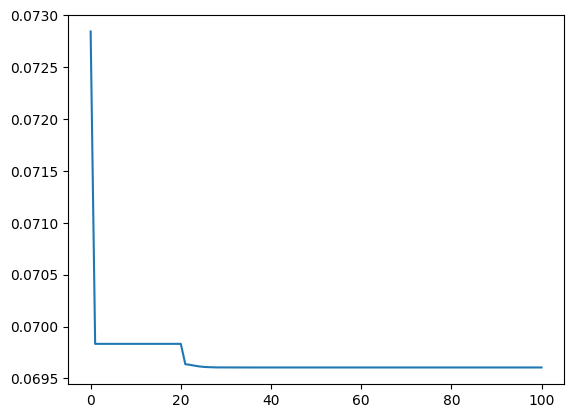

In [ ]:
import matplotlib.pyplot as plt
gaps = [v[0] for k,v in resPairFW["gap"].items()]
plt.plot([i for i in range(len(gaps))], gaps)

Text(0, 0.5, 'Dual')

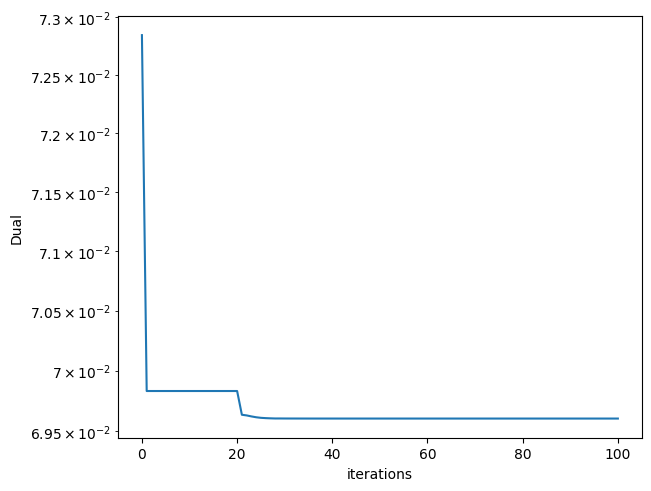

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.scale as mscale
from matplotlib.ticker import FixedLocator, NullFormatter

fig, axs = plt.subplot_mosaic([['log']], layout='constrained')

ax = axs['log']
gaps = [v[0] for k,v in resPairFW["gap"].items()]
ax.plot([i for i in range(len(gaps))], gaps)
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xlabel('iterations')
ax.set_ylabel('Dual')

Text(0, 0.5, 'Primal')

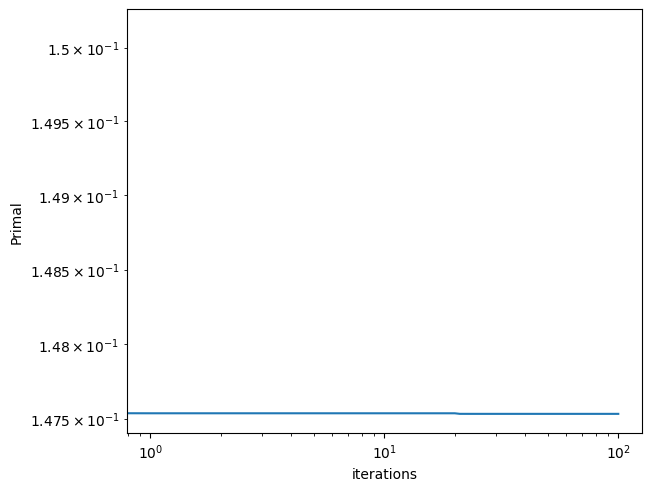

In [ ]:

fig, axs = plt.subplot_mosaic([['log']], layout='constrained')

ax = axs['log']
gaps = [v[0] for k,v in resPairFW["primal"].items()]
ax.plot([i for i in range(len(gaps))], gaps)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Primal')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45a6f0fe-6c45-41e2-abb2-c5529ab4ae4f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>